In [1]:
%run ../macro_tQ.py
import sys
sys.path.append('../')
import macro_tQ as tQ

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [2]:
def TFC(n):
    qc = QuantumCircuit(n)    

    for j in reversed(range(n)):
        qc.h(j)
        for k in range(j):
            qc.cp(np.pi/2**(j-k), k, j)
    for j in range(n//2):
        qc.swap(j,n-j-1)

    return qc.to_gate(label='TFC')
        

/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


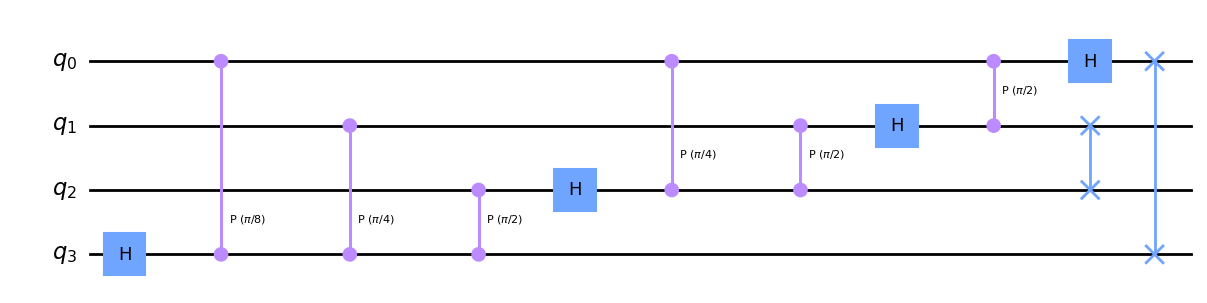

In [3]:
TFC(4).definition.draw('mpl')

In [4]:
def TFC_adj(n):
    qc = QuantumCircuit(n)    

    for j in reversed(range(n//2)):
        qc.swap(j,n-j-1)            
    for j in range(n):
        for k in reversed(range(j)):
            qc.cp(-2*np.pi/2**(j-k+1), k, j)
        qc.h(j)

    return qc.to_gate(label='TFC_adj')

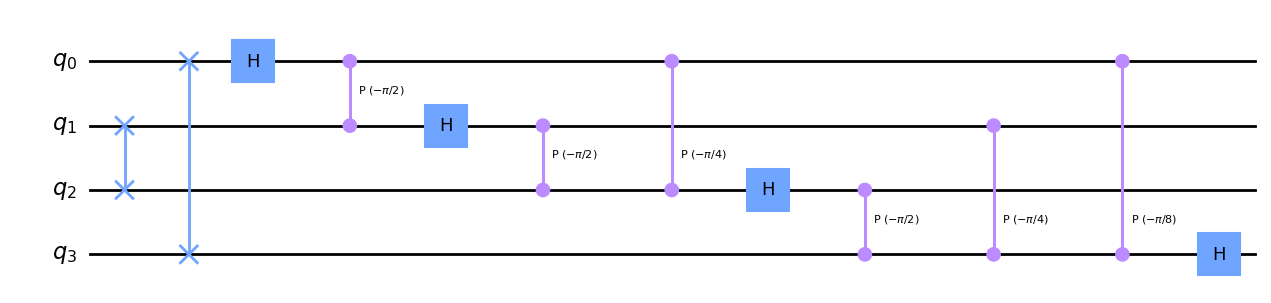

In [5]:
TFC_adj(4).definition.draw('mpl')

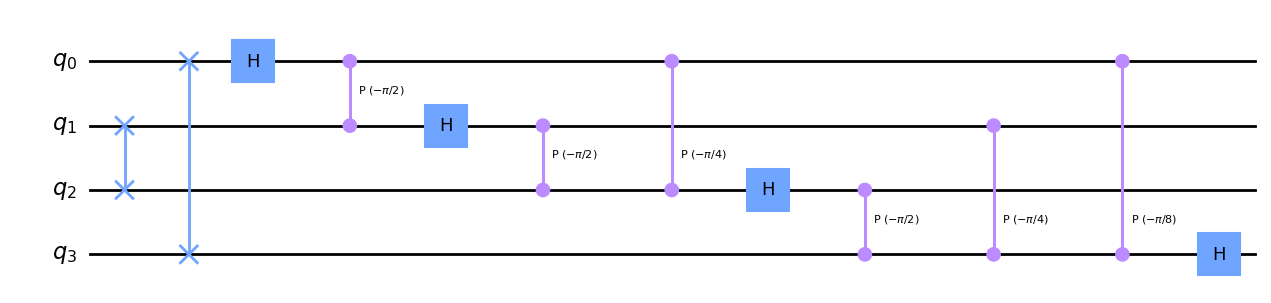

In [6]:
TFC(4).inverse().definition.draw('mpl')

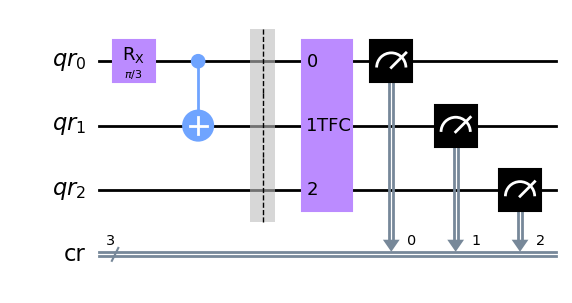

In [7]:
# Creamos el circuito 
num_qubits=3
qr = QuantumRegister(num_qubits,name='qr')
cr = ClassicalRegister(num_qubits,name='cr')
qc = QuantumCircuit(qr,cr,name="QFT")

# Inicialización 1 de un estado de entrada
qc.rx(np.pi/3,0)
qc.cx(0,1)
#qc.x(0)

# Inicialización 2 de un estado de entrada
#qc.h(range(num_qubits))

qc.barrier()
        
# añadimos la TFC
qc.append(TFC(num_qubits),qr[:])

qc.measure(qr,cr)

qc.draw(output='mpl')

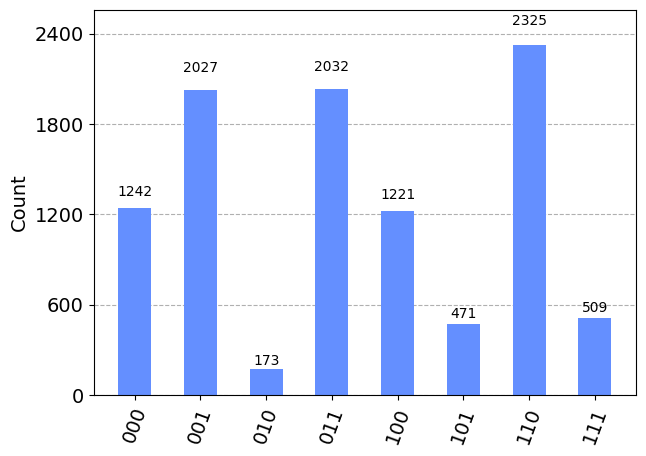

In [8]:

from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector

M_simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc,backend=M_simulator,shots =10000 ).result().get_counts()
plot_histogram(counts)

In [9]:
def f_periodica(Nn,Nm,P,show_values=True): # hay argumentos Nn y Nm para el caso de funciones de S_n -> S_m
    
    M= int(Nn/P)
    values= np.random.choice(Nm-1,P,replace=False) #seleccionamos P valores aleatorios entre 1 y Np 
    if show_values:
        print('valores de f(x) en un período :',values)
    
    fout=np.zeros(Nn)
    for m in range(M+1):
        for p in range(P):  
            if p + m*P < Nn:
                fout[p + m*P] = values[p]
#    print('tabla binaria de verdad completa de la función f(x):',  fout)
    fout_list = [format(int(i), 'b').zfill(int(np.ceil(np.log2(np.max(fout)+2)))) for i in fout]
    
    return fout_list
      
fout_list = f_periodica(8,8,4,show_values=True)        
print(fout_list)

valores de f(x) en un período : [3 4 6 5]
['011', '100', '110', '101', '011', '100', '110', '101']


/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


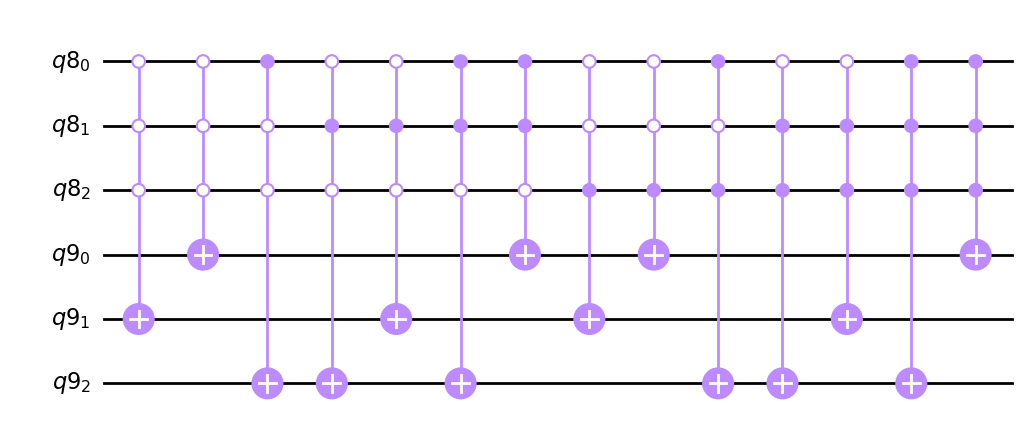

In [10]:
binary_function(fout_list).draw('mpl')

In [11]:


n=7
#dominio
Nn=2**n
#rango
Nm = N  # esta opción no es obligatoria. Sólo es necesario que N'>P
#período
P =5

print('N = 2^n =',Nn, ' P =', P, ' M =', N/P)

# el oráculo que genera una funcion períodica con valores f(0),f(1),...,f(P-1) que se repiten M veces (aprox)
fout_list = f_periodica(Nn,Nm,P,show_values=True)        
periodic_oracle = binary_function(fout_list).to_gate(label='f(x+P)=f(x)')

qr_in = QuantumRegister(n, name='x')
qr_out = QuantumRegister(n, name='f(x)')
cr_in = ClassicalRegister(n, name='meas_in')
cr_out = ClassicalRegister(n, name='meas_out')
qc = QuantumCircuit(qr_in, qr_out, cr_in,cr_out, name='q')
    

# Aplicamos la puerta de Walsh-Hadamard al primer registro
qc.h(qr_in)
qc.barrier()

# Añadimos el oráculo
qc.append(periodic_oracle,qr_in[:] + qr_out[:])    
qc.barrier()

# Medimos el registro de los cúbits de |f(x)>
qc.measure(qr_out, cr_out)
qc.barrier()

# Aplicamos la Transformada de Fourier al primer registro
qc.append(TFC(n),qr_in)
qc.barrier()

# Finalmente medimos el registro de los inputs |x>
qc.measure(qr_in, cr_in)   

NameError: name 'N' is not defined

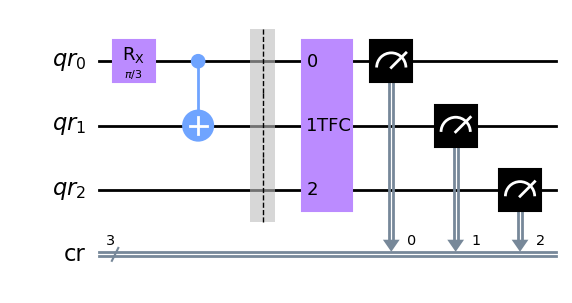

In [12]:
qc.draw('mpl')

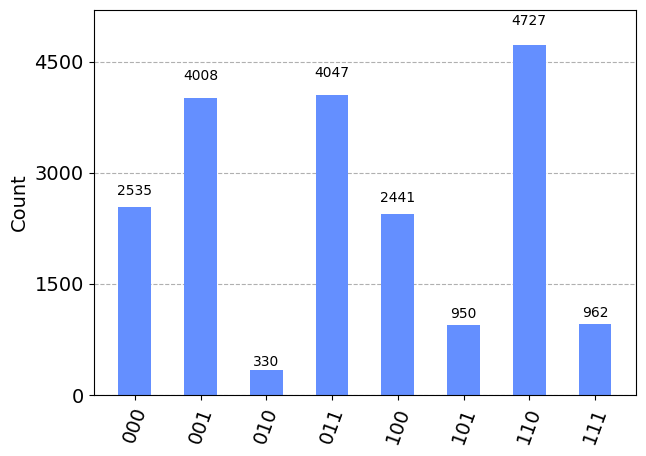

In [13]:
from qiskit import Aer, execute

shots_exe = 20000

backend = Aer.get_backend('qasm_simulator')
job     = execute(qc, backend, shots = shots_exe)
result  = job.result()
counts  = result.get_counts()

from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

In [14]:
#post-selección

projected_counts = {k: v for k, v in counts.items() if k[:len(k)//2] == list(counts)[2][:n] and v>300 }
#print(projected_counts)
plot_histogram(projected_counts)


StopIteration: 

In [15]:
# extraemos las 'keys' del segundo registro, rechazando el 00...0 que siempre está
Ns_list = sorted([int(keys[n+1:],2) for  keys in projected_counts])[1:] # el +1 es para comerse el espacio p.ej en '101 1101'
print('{Ns} ~ ', Ns_list)

# dividiendo por N
phis_list = [Ns_list[i]/N for i in range(len(Ns_list))]
print('phi_s', phis_list)


{Ns} ~  []
phi_s []


In [16]:
P_list = [(phis_list[s+1]-phis_list[s])**(-1) for s in range(len(phis_list)-1)]

print(P_list)

print('el valor entero del promedio =', int(sum(P_list)/len(P_list)))

[]


ZeroDivisionError: division by zero

In [17]:
from fractions import Fraction

[Fraction(phis_list[i]) for i in range(len(phis_list))]

[]

In [18]:
[Fraction(phis_list[i]).limit_denominator(20) for i in range(int(len(phis_list)))]

[]